In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
%%time
data_raw=pd.read_csv('table_1232.csv', header=0)# Считываем данные из файла

Wall time: 20 ms


In [4]:
data_raw.tail() #Проверяем данные

Day_hour    1232
3643  2016-05-31 19:00:00  1092.0
3644  2016-05-31 20:00:00  1170.0
3645  2016-05-31 21:00:00  1438.0
3646  2016-05-31 22:00:00  1365.0
3647  2016-05-31 23:00:00   925.0

<Figure size 1224x576 with 0 Axes>

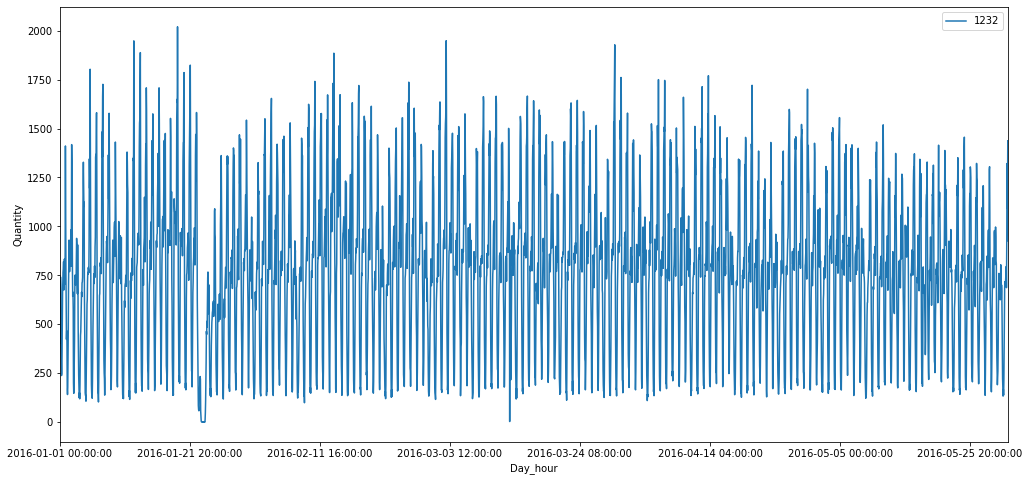

In [5]:
# Построим график нашего ряда.
plt.figure(figsize(17,8))
data_raw.plot(x='Day_hour', y='1232')
plt.xlabel('Day_hour')
plt.ylabel('Quantity')
pylab.show()

Видно наличие сезонностей, суточной и вероятно недельной, видим аномальные даты. Тренда вроде бы нет.

#### Выберите одну из зон среди отобранных на прошлой неделе, возьмите по ней все подготовленные данные о количестве поездок. Не используйте данные за последний имеющийся месяц — июнь 2016! Создайте регрессионные признаки для учёта сезонностей и трендов.

In [6]:
 #Создаем массив временных меток для ряда. Потом будем использовать его для расчета регрессионных признаков
time=np.array(data_raw.index[:])

In [7]:
time.shape #Проверяем длину массива временных меток.

(3648,)

In [41]:
#Создадим массивы названий регрессионных признаков
sinuses=['s1','s2','s3','s4','s5','s6','s7']
cosins=['c1', 'c2','c3','c4','c5','c6','c7']

In [42]:
data=data_raw.copy(deep=True)# Копируем данные

In [43]:
%%time
#Добавляем в таблицу столбцы с признаками
for i in range(len(sinuses)):
    data[sinuses[i]]=np.sin((time+1)*2*3.14*(i+1)/168)
    data[cosins[i]]=np.cos((time+1)*2*3.14*(i+1)/168)

Wall time: 13 ms


In [44]:
data.head() #Смотрим что получилось

Day_hour   1232        s1        c1        s2        c2  \
0  2016-01-01 00:00:00  403.0  0.037372  0.999301  0.074692  0.997207   
1  2016-01-01 01:00:00  420.0  0.074692  0.997207  0.148967  0.988842   
2  2016-01-01 02:00:00  484.0  0.111908  0.993719  0.222410  0.974953   
3  2016-01-01 03:00:00  742.0  0.148967  0.988842  0.294610  0.955618   
4  2016-01-01 04:00:00  701.0  0.185818  0.982584  0.365165  0.930943   

         s3        c3        s4        c4        s5        c5        s6  \
0  0.111908  0.993719  0.148967  0.988842  0.185818  0.982584  0.222410   
1  0.222410  0.974953  0.294610  0.955618  0.365165  0.930943  0.433679   
2  0.330118  0.943940  0.433679  0.901068  0.531791  0.846875  0.623223   
3  0.433679  0.901068  0.563069  0.826410  0.679895  0.733310  0.781548   
4  0.531791  0.846875  0.679895  0.733310  0.804316  0.594202  0.900722   

         c6        s7        c7  
0  0.974953  0.258691  0.965960  
1  0.901068  0.499770  0.866158  
2  0.782044  0.706825  0.707388  
3  0.623846  0.865760  0.500460  
4  0.434396  0.965754  0.259460

In [45]:
data.tail()

Day_hour    1232        s1        c1        s2        c2  \
3643  2016-05-31 19:00:00  1092.0 -0.903431 -0.428733  0.774662 -0.632376   
3644  2016-05-31 20:00:00  1170.0 -0.918823 -0.394670  0.725264 -0.688471   
3645  2016-05-31 21:00:00  1438.0 -0.932931 -0.360056  0.671815 -0.740719   
3646  2016-05-31 22:00:00  1365.0 -0.945735 -0.324939  0.614612 -0.788829   
3647  2016-05-31 23:00:00   925.0 -0.957218 -0.289368  0.553976 -0.832533   

            s3        c3        s4        c4        s5        c5        s6  \
3643  0.239185  0.970974 -0.979755 -0.200201  0.600921 -0.799308  0.464485   
3644  0.346342  0.938108 -0.998646 -0.052016  0.441930 -0.897050  0.649813   
3645  0.449149  0.893457 -0.995252  0.097330  0.267545 -0.963545  0.802590   
3646  0.546312  0.837582 -0.969648  0.244504  0.083841 -0.996479  0.915162   
3647  0.636613  0.771184 -0.922406  0.386222 -0.102784 -0.994704  0.981891   

            c6        s7        c7  
3643  0.885581 -0.999202  0.039952  
3644  0.760094 -0.954854  0.297077  
3645  0.596531 -0.845500  0.533976  
3646  0.403086 -0.678584  0.734523  
3647  0.189449 -0.465471  0.885063

#### Чтобы примерно подобрать порядки дифференцирования ряда в модели ARIMA, сделайте регрессию целевого признака — количества поездок — на построенные признаки. Посмотрите на остатки регрессии. Если регрессионные признаки подобраны идеально, то в них должна остаться только внутрисуточная сезонность. Вслепую идеально подобрать признаки вам вряд ли удастся, так что в остатках вы, скорее всего, увидите много интересного, в том числе праздники, аномалии, тренды и многое другое.

Для линейной регрессии будем использовать модуль LinearRegression

Для начала сделаем регрессию по трем парам признаков

In [46]:
%%time
# Создаем регрессор. Обучаем. Делаем предсказание.
lr = LinearRegression()
lr.fit(data[['s1', 'c1', 's2', 'c2', 's3', 'c3']], data['1232'])
prediction = lr.predict(data[['s1', 'c1', 's2', 'c2', 's3', 'c3']])

Wall time: 10 ms


In [47]:
data['prediction1']=prediction #Добавляем столбец предсказаний в данные

In [48]:
data.head()

Day_hour   1232        s1        c1        s2        c2  \
0  2016-01-01 00:00:00  403.0  0.037372  0.999301  0.074692  0.997207   
1  2016-01-01 01:00:00  420.0  0.074692  0.997207  0.148967  0.988842   
2  2016-01-01 02:00:00  484.0  0.111908  0.993719  0.222410  0.974953   
3  2016-01-01 03:00:00  742.0  0.148967  0.988842  0.294610  0.955618   
4  2016-01-01 04:00:00  701.0  0.185818  0.982584  0.365165  0.930943   

         s3        c3        s4        c4        s5        c5        s6  \
0  0.111908  0.993719  0.148967  0.988842  0.185818  0.982584  0.222410   
1  0.222410  0.974953  0.294610  0.955618  0.365165  0.930943  0.433679   
2  0.330118  0.943940  0.433679  0.901068  0.531791  0.846875  0.623223   
3  0.433679  0.901068  0.563069  0.826410  0.679895  0.733310  0.781548   
4  0.531791  0.846875  0.679895  0.733310  0.804316  0.594202  0.900722   

         c6        s7        c7  prediction1  
0  0.974953  0.258691  0.965960   833.626643  
1  0.901068  0.499770  0.866158   831.494346  
2  0.782044  0.706825  0.707388   829.274378  
3  0.623846  0.865760  0.500460   826.994372  
4  0.434396  0.965754  0.259460   824.682669

Построим графики ряда поездок и предсказаний линейного регрессора. Возьмем только февраль. Иначе получается не очень читаемая картинка.

<Figure size 1224x576 with 0 Axes>

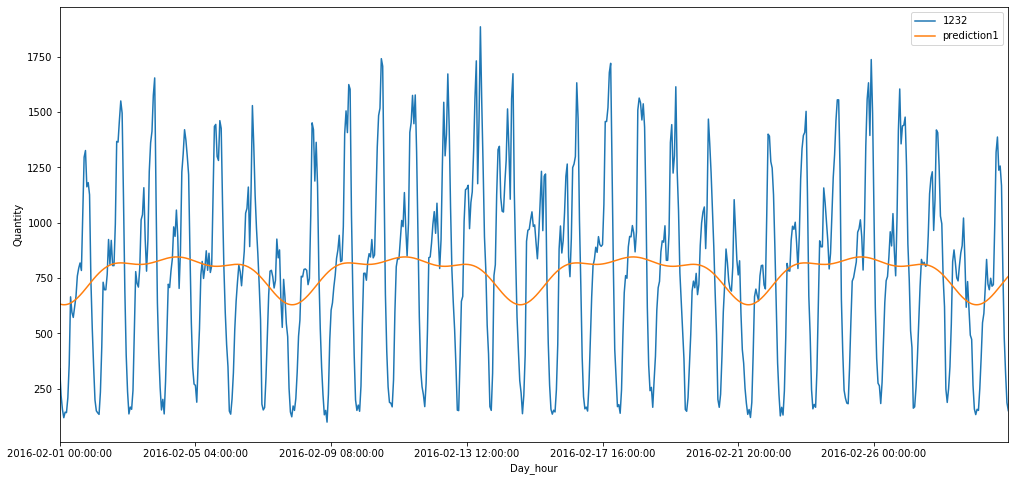

In [49]:
# Строим график количества поездок по времени на февраль
plt.figure(figsize(17,8))
data[744:700+744].plot(x='Day_hour', y=['1232', 'prediction1'])
plt.xlabel('Day_hour')
plt.ylabel('Quantity')
pylab.show()

In [50]:
lr.coef_ # Значения коэффициентов линейного регрессора

array([-27.00233982,  75.02585421,  20.89474284, -32.84535305,
       -22.34003124,  17.34460998])

In [51]:
data['resid1']=data['1232']-data['prediction1'] # Добавляем в данные столбец с остатками регрессии

Построим график остатков. Тоже только для февраля.

<Figure size 1224x576 with 0 Axes>

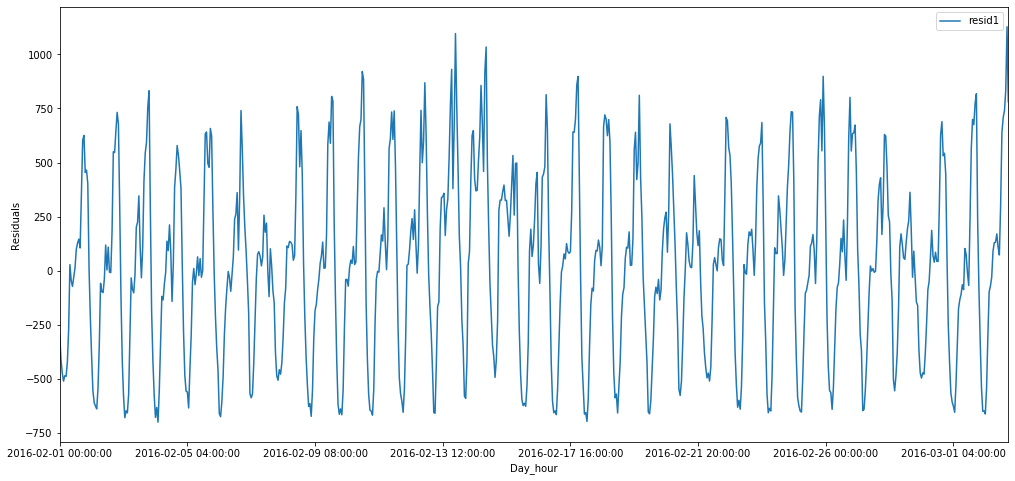

In [52]:
# Строим график остатков по времени для февраля
plt.figure(figsize(17,8))
data[744:744*2].plot(x='Day_hour', y='resid1')
plt.xlabel('Day_hour')
plt.ylabel('Residuals')
pylab.show()

<Figure size 1224x576 with 0 Axes>

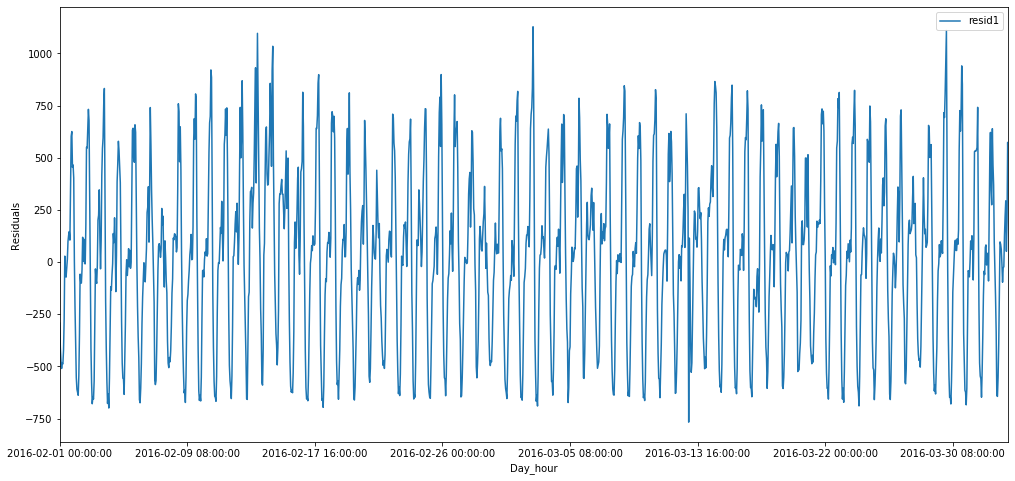

In [53]:
# Строим график остатков по времени для февраля и марта
plt.figure(figsize(17,8))
data[744:744*3].plot(x='Day_hour', y='resid1')
plt.xlabel('Day_hour')
plt.ylabel('Residuals')
pylab.show()

Что можно сказать про график остатков:
1. Есть суточная сезонность и, похоже, недельна.
2. Месячной сезонности я не вижу.
3. Есть аномалии - празники, дни с повышенным и пониженным спросом на такси.
4. Тренда вроде бы не видно.

#### Чтобы подобрать значения гиперпараметров ARIMA, попробуйте сделать ряд остатков стационарным. Если необходимо, сделайте несколько дифференцирований. Из-за большого количества аномальных дней (праздники и т.д.) вряд ли вам удастся сделать так, что критерий Дики-Фуллера не будет отвергать гипотезу нестационарности, поэтому при выборе порядка дифференцирования ориентируйтесь в первую очередь на результат STL-декомпозиции.
#### Постройте ACF и PACF полученного ряда остатков (возможно, продифференцированных) с максимальным лагом не меньше длины самого длинного сезонного периода (неделя или год), подберите по ним начальные приближения для параметров ( (p, q, P, Q) ). Используйте эти начальные приближения при переборе моделей ARIMA исходного ряда, не забывая подавать функции SARIMAX регрессионные признаки в качестве параметра exog.

In [54]:
#Посчитаем критерий Дики-Фуллера для остатков.
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.resid1)[1])

Критерий Дики-Фуллера: p=0.000000


Интересное кино получается - Дикий Фуллер говорит, что ряд остатков после регрессии вполне себе стационарен.

In [55]:
# Для STL декомпозиции и построения ACF и PACF нужна таблица, где индексы это дата и время. Преобразуем индекы таблицы данных.
data.index=pd.to_datetime(data.Day_hour)

In [56]:
data.head()

Day_hour   1232        s1        c1        s2  \
Day_hour                                                                        
2016-01-01 00:00:00  2016-01-01 00:00:00  403.0  0.037372  0.999301  0.074692   
2016-01-01 01:00:00  2016-01-01 01:00:00  420.0  0.074692  0.997207  0.148967   
2016-01-01 02:00:00  2016-01-01 02:00:00  484.0  0.111908  0.993719  0.222410   
2016-01-01 03:00:00  2016-01-01 03:00:00  742.0  0.148967  0.988842  0.294610   
2016-01-01 04:00:00  2016-01-01 04:00:00  701.0  0.185818  0.982584  0.365165   

                           c2        s3        c3        s4        c4  \
Day_hour                                                                
2016-01-01 00:00:00  0.997207  0.111908  0.993719  0.148967  0.988842   
2016-01-01 01:00:00  0.988842  0.222410  0.974953  0.294610  0.955618   
2016-01-01 02:00:00  0.974953  0.330118  0.943940  0.433679  0.901068   
2016-01-01 03:00:00  0.955618  0.433679  0.901068  0.563069  0.826410   
2016-01-01 04:00:00  0.930943  0.531791  0.846875  0.679895  0.733310   

                           s5        c5        s6        c6        s7  \
Day_hour                                                                
2016-01-01 00:00:00  0.185818  0.982584  0.222410  0.974953  0.258691   
2016-01-01 01:00:00  0.365165  0.930943  0.433679  0.901068  0.499770   
2016-01-01 02:00:00  0.531791  0.846875  0.623223  0.782044  0.706825   
2016-01-01 03:00:00  0.679895  0.733310  0.781548  0.623846  0.865760   
2016-01-01 04:00:00  0.804316  0.594202  0.900722  0.434396  0.965754   

                           c7  prediction1      resid1  
Day_hour                                                
2016-01-01 00:00:00  0.965960   833.626643 -430.626643  
2016-01-01 01:00:00  0.866158   831.494346 -411.494346  
2016-01-01 02:00:00  0.707388   829.274378 -345.274378  
2016-01-01 03:00:00  0.500460   826.994372  -84.994372  
2016-01-01 04:00:00  0.259460   824.682669 -123.682669

<Figure size 1080x1080 with 0 Axes>

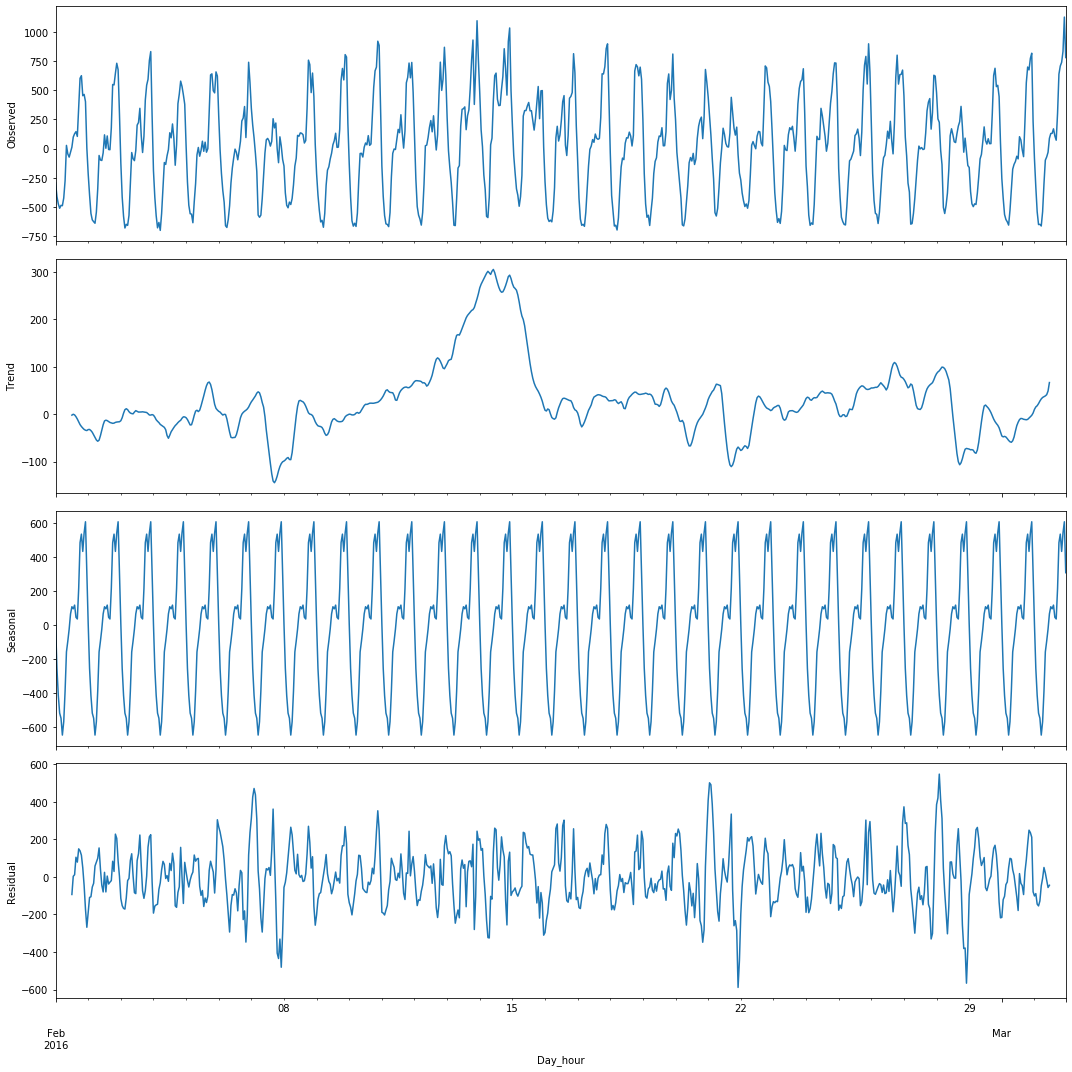

In [57]:
#Сделаем STL-декомпозицию. Возьмем только один месяц, например февраль. Если брать весь период, графики получаются не удобными
# для визуального анализа.
plt.figure(figsize(15,15))
sm.tsa.seasonal_decompose(data.iloc[744:744*2].resid1).plot()
pylab.show()

Графики выглядят приемлемо. Тренда нет. Стационарность есть.
Построим автокореляцию и частичную автокореляцию для необработанного ряда, так как он уже стационарен. И посмотрим можем ли выбрать параметры модели SARIMAX по этому ряду.

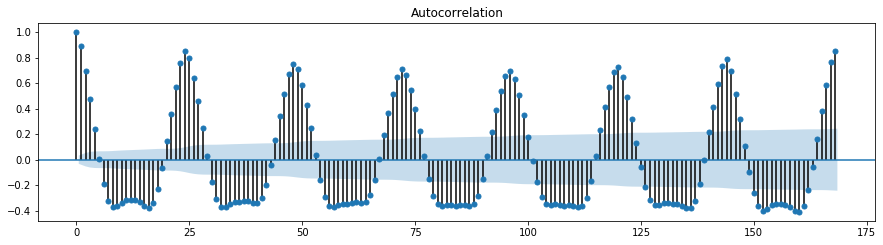

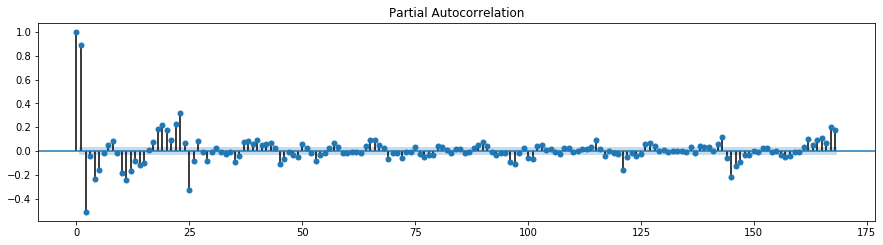

In [58]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.resid1.values.squeeze(), lags=168, ax=ax)#Строит автокреляцию
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.resid1.values.squeeze(), lags=168, ax=ax)#Строит частичную автокореляцию
pylab.show()

График автокореляции показывает много сезонных и не сезонных лагов с высокой кореляцией.
Сделаем сезонное дифференцирование.

In [59]:
data['resid1_sez'] = data.resid1 - data.resid1.shift(24)#Сезонное дифференцирование по суткам

<Figure size 1080x1080 with 0 Axes>

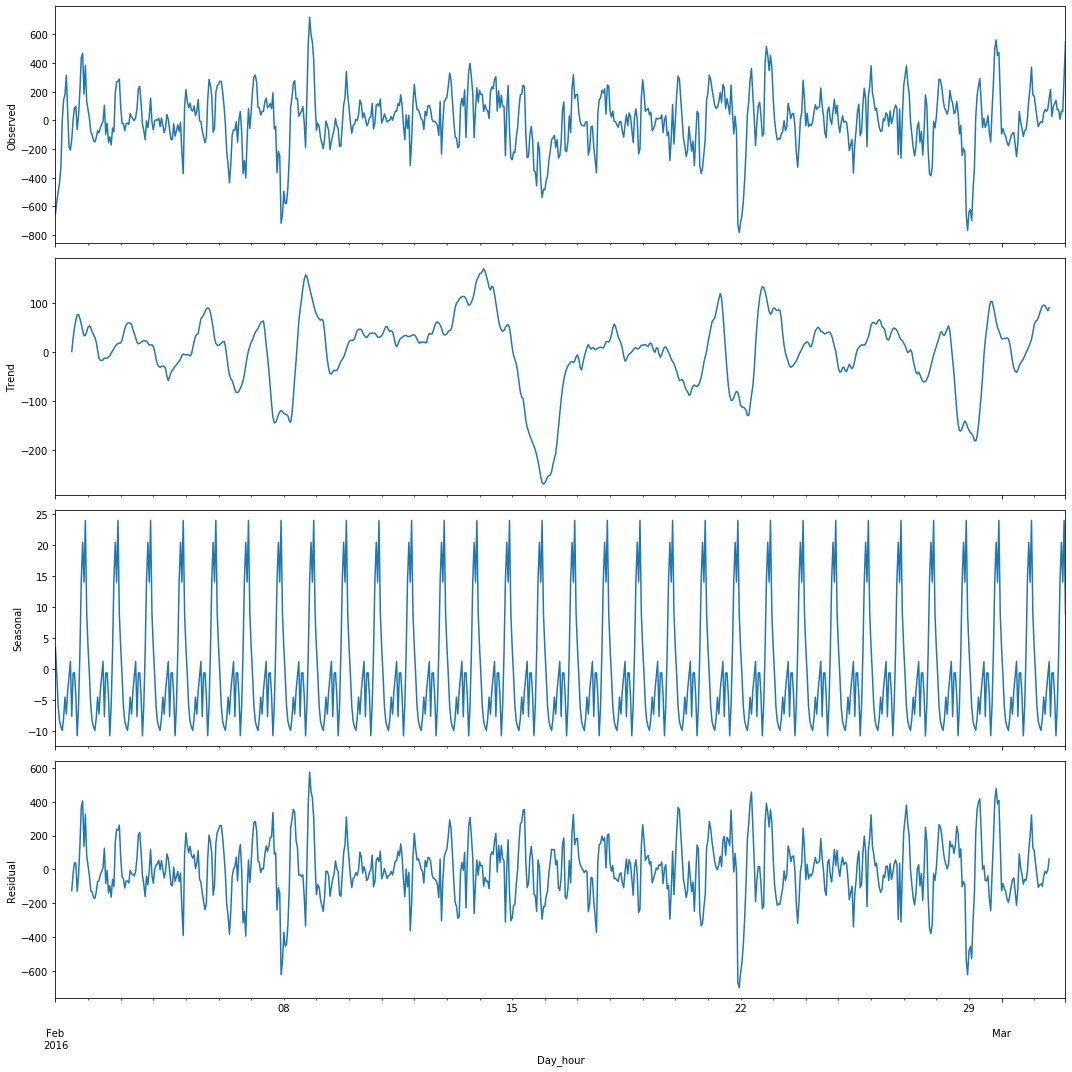

In [60]:
#Сделаем STL-декомпозицию для ряда дифференцированного сезонно.
plt.figure(figsize(15,15))
sm.tsa.seasonal_decompose(data.iloc[744:744*2].resid1_sez).plot()
pylab.show()

Вроде стало покрасивее. Но для пущей лучшести сделаем и простое диференцирование.

In [61]:
data['resid1_sez_diff'] = data.resid1_sez - data.resid1_sez.shift(1)#Простое дифференцирование

<Figure size 1080x1080 with 0 Axes>

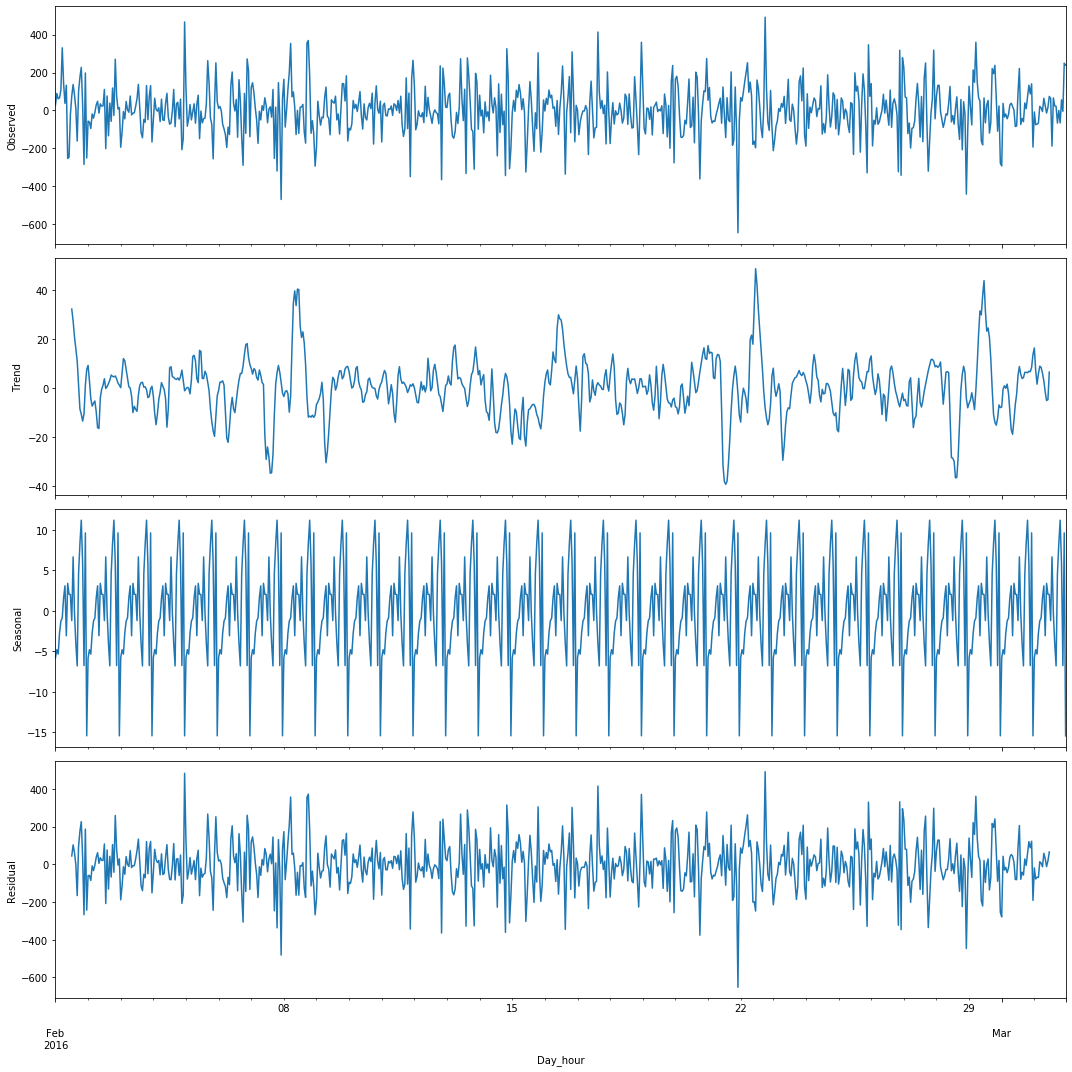

In [62]:
#Сделаем STL-декомпозицию.
plt.figure(figsize(15,15))
sm.tsa.seasonal_decompose(data.iloc[744:744*2].resid1_sez_diff).plot()
pylab.show()

Вроде стало еще лучше.
Построим графики автокореляционной и частичной автокореляционной функций.

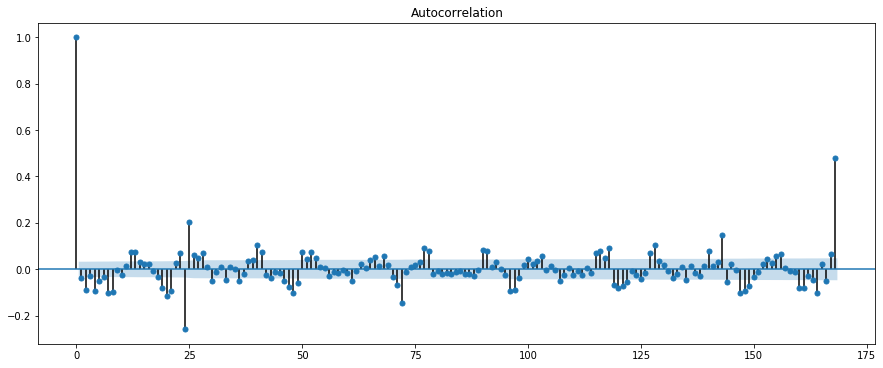

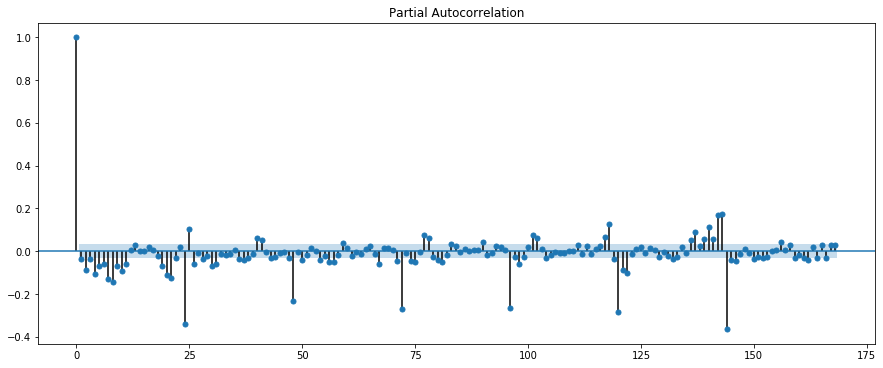

In [63]:
plt.figure(figsize(15,13))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.resid1_sez_diff[25:].values.squeeze(), lags=168, ax=ax)#Строит автокреляцию
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.resid1_sez_diff[25:].values.squeeze(), lags=168, ax=ax)#Строит частичную автокореляцию
pylab.show()

ACF и PACF выглядят не очень хорошо.
Сделаем простое дифференцирование еще раз.

In [64]:
data['resid1_sez_diff_diff'] = data.resid1_sez_diff - data.resid1_sez_diff.shift(1)#Простое дифференцирование еще раз

<Figure size 1080x1080 with 0 Axes>

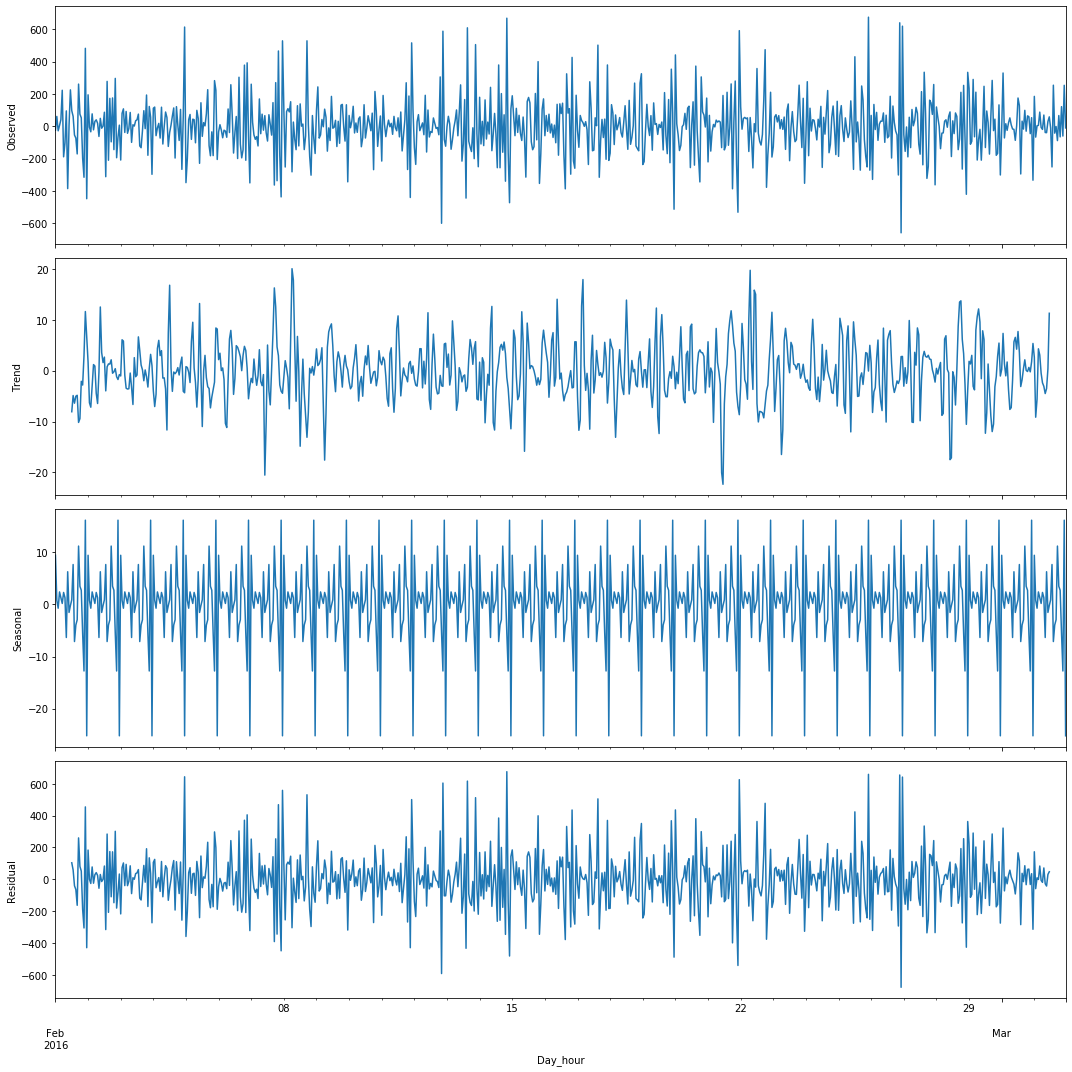

In [65]:
#Сделаем STL-декомпозицию.
plt.figure(figsize(15,15))
sm.tsa.seasonal_decompose(data.iloc[744:744*2].resid1_sez_diff_diff).plot()
pylab.show()

Построим ACF и PACF.

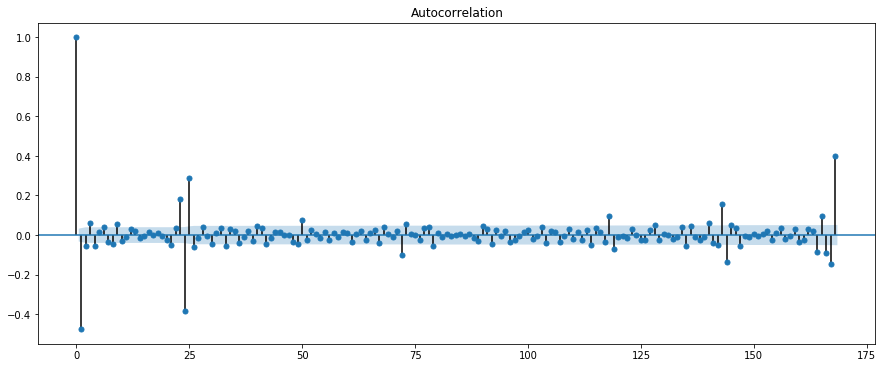

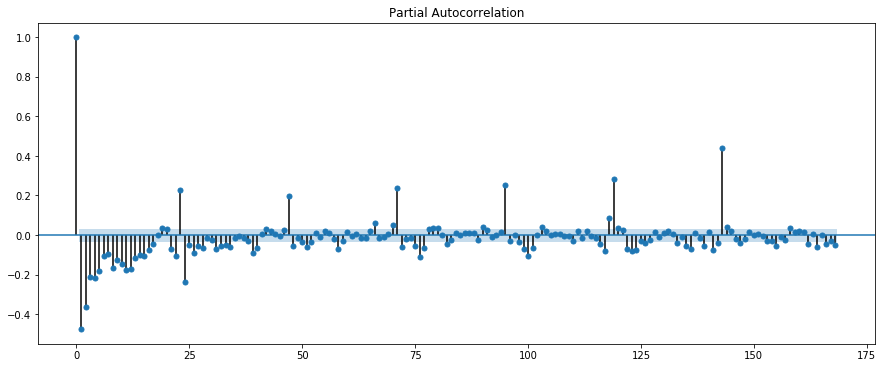

In [66]:
plt.figure(figsize(15,13))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.resid1_sez_diff_diff[26:].values.squeeze(), lags=168, ax=ax)#Строит автокреляцию
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.resid1_sez_diff_diff[26:].values.squeeze(), lags=168, ax=ax)#Строит частичную автокореляцию
pylab.show()

Попробуем остановиться с дифференцированием на этом этапе. Возьмем первые приближения параметров SARIMы из автокореляции и частичной автокореляции после одного сезонного и двух обычных дифференцирований. D=1, d=2, Q=1, q=1, P=1, p=2

#### Выберите оптимальную по AIC модель; постройте график исходного ряда и нарисуйте поверх предсказания выбранной модели. Если модель плохо описывает данные, попробуйте увеличить количество синусов и косинусов \( (K) \) или поменять порядки дифференцирования.

In [67]:
#Создадим отдельные дата-сеты целевого признака и регрессионных признаков. Надеюсь это ускорит процесс обучения модели.
target1=data['resid1'].copy(deep=True)
exog1=data[['s1','c1','s2','c2','s3','c3']].copy(deep=True)

In [68]:
print(np.array(range(1, 3)))
print(np.array(range(0, 2)))

[1 2]
[0 1]


In [69]:
target1.head()

Day_hour
2016-01-01 00:00:00   -430.626643
2016-01-01 01:00:00   -411.494346
2016-01-01 02:00:00   -345.274378
2016-01-01 03:00:00    -84.994372
2016-01-01 04:00:00   -123.682669
Name: resid1, dtype: float64

In [70]:
exog1.head()

s1        c1        s2        c2        s3  \
Day_hour                                                                
2016-01-01 00:00:00  0.037372  0.999301  0.074692  0.997207  0.111908   
2016-01-01 01:00:00  0.074692  0.997207  0.148967  0.988842  0.222410   
2016-01-01 02:00:00  0.111908  0.993719  0.222410  0.974953  0.330118   
2016-01-01 03:00:00  0.148967  0.988842  0.294610  0.955618  0.433679   
2016-01-01 04:00:00  0.185818  0.982584  0.365165  0.930943  0.531791   

                           c3  
Day_hour                       
2016-01-01 00:00:00  0.993719  
2016-01-01 01:00:00  0.974953  
2016-01-01 02:00:00  0.943940  
2016-01-01 03:00:00  0.901068  
2016-01-01 04:00:00  0.846875

In [4]:
#Задаем интервалы, в которых будем перебирать значения параметров модели ARIMA
ps = range(1, 3)
d=2
qs = range(1, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)


In [2]:
from itertools import product

In [5]:
#Создаем массив комбинаций параметров
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters) 
len(parameters_list)

16

Находим оптимальные параметры модели

In [74]:
%%time
results1 = []
best_aic1 = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model1=sm.tsa.statespace.SARIMAX(target1, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24),
                                        exog=exog1).fit(disp=-1, maxiter=20)
    
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic1 = model1.aic
    #сохраняем лучшую модель, aic, параметры
    if aic1 < best_aic1:
        best_model1 = model1
        best_aic1 = aic1
        best_param1 = param
    results1.append([param, model1.aic])
    
warnings.filterwarnings('default')

Wall time: 24min 44s


In [76]:
#Создаем таблицу результатов настроек моделей
result_table1 = pd.DataFrame(results1)
result_table1.columns = ['parameters', 'aic']
print(result_table1.sort_values(by = 'aic', ascending=True).head())

      parameters           aic
11  (2, 1, 1, 1)  44462.668148
3   (1, 1, 1, 1)  44472.214908
15  (2, 2, 1, 1)  44476.216329
7   (1, 2, 1, 1)  44480.310053
5   (1, 2, 0, 1)  44694.411097


Лучшая модель:

In [77]:
print(best_model1.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             resid1   No. Observations:                 3648
Model:             SARIMAX(2, 2, 1)x(1, 1, 1, 24)   Log Likelihood              -22219.334
Date:                            Wed, 28 Aug 2019   AIC                          44462.668
Time:                                    11:25:27   BIC                          44537.006
Sample:                                01-01-2016   HQIC                         44489.152
                                     - 05-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
s1          -156.9537     94.204     -1.666      0.096    -341.591      27.684
c1           149.7867     95.417   

Проанализируем остатки:

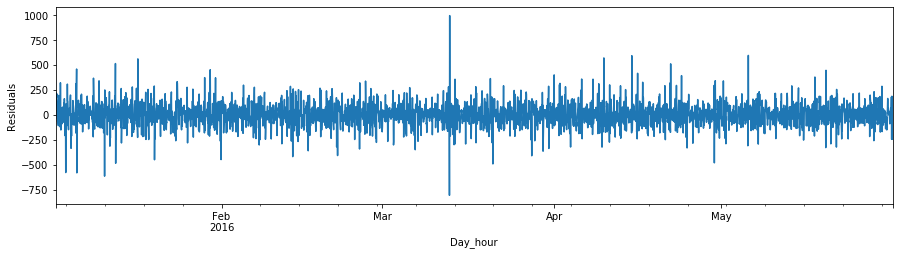

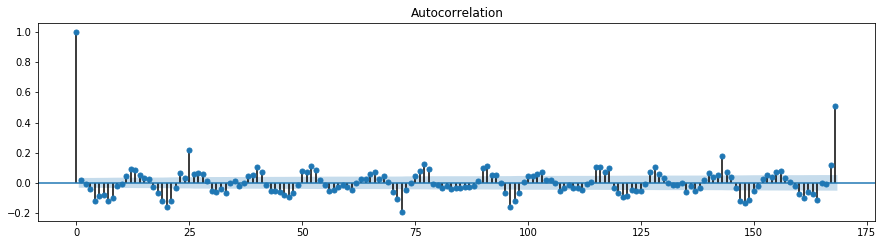

Критерий Стьюдента: p=0.424307
Критерий Дики-Фуллера: p=0.000000


In [78]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model1.resid[26:].plot() #Так рисуем график остатков модели
plt.ylabel(u'Residuals')
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model1.resid[26:].values.squeeze(), lags=168, ax=ax)#Рисуем график автокореляции остатсков модели
pylab.show()
#Считаем крит Стюд гипотезы о несмещенности остатков (нормальное распределение вокруг нуля)
print("Критерий Стьюдента: p=%f" % scs.ttest_1samp(best_model1.resid[26:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model1.resid[26:])[1])#Считаем крит Дики-Фулера для остатков

Остатки не смещены (критерий Стьюдента) и стационарны (критерий Дики-Фуллера)

In [79]:
#Добавляем предсказания модели в данные
data['sarimax1']=data.prediction1+best_model1.fittedvalues

Построим графики фактического значения поездок и предсказаний модели. Помесячно, чтоб было удобно анализировать.

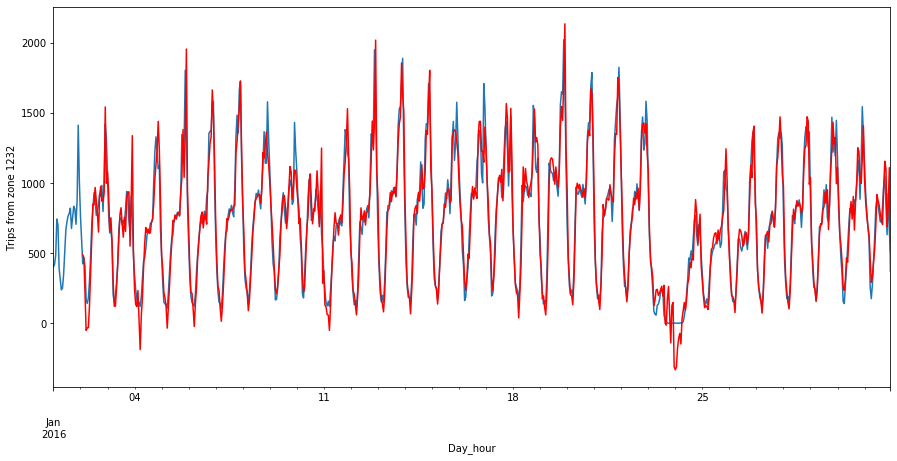

In [80]:
# Строим графики фактического значения данных и предсказаний за янвраль
plt.figure(figsize(15,7))
data['1232'][0:744].plot()
data.sarimax1[26:744].plot(color='r')
plt.ylabel('Trips from zone 1232')
pylab.show()

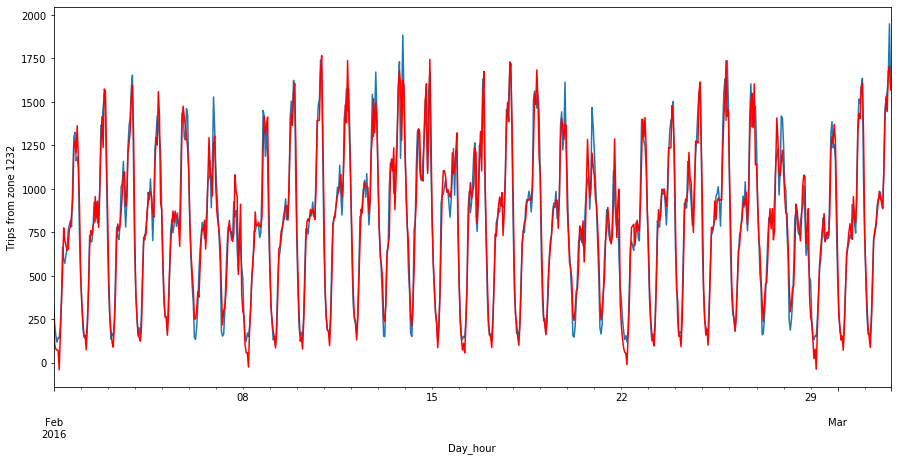

In [81]:
# Строим графики фактического значения данных и предсказаний за февраль
plt.figure(figsize(15,7))
data['1232'][744:744*2].plot()
data.sarimax1[744:744*2].plot(color='r')
plt.ylabel('Trips from zone 1232')
pylab.show()

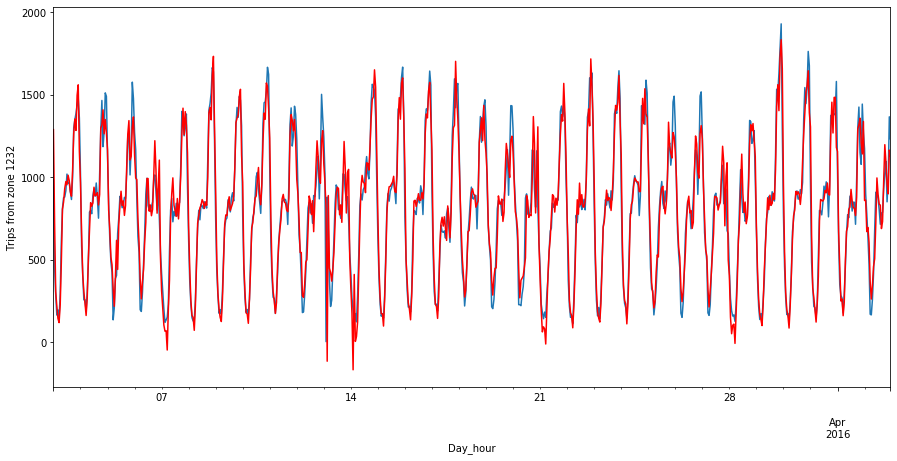

In [82]:
# Строим графики фактического значения данных и предсказаний за март
plt.figure(figsize(15,7))
data['1232'][744*2:744*3].plot()
data.sarimax1[744*2:744*3].plot(color='r')
plt.ylabel('Trips from zone 1232')
pylab.show()

Что мы видим на графиках:
1. Модель достаточно хорошо отрабатывает обычные дни_часы. Бывает дает значения поездок меньше нуля.
2. Модель не хорошо отрабатывает экстремальные дни_часы. В январе провал нашелся, но количество поездок спрогнозировалось плохо.
Попробую добавить регрессионных признаков и сделать все еще раз. Может будет лучше.

Делаем регрессию по пяти парам признаков. Причем первые две пары не будем использовать.

In [83]:
%%time
# Создаем регрессор. Обучаем. Делаем предсказание.
lr1 = LinearRegression()
lr1.fit(data[['s3', 'c3', 's4', 'c4', 's5', 'c5','s6','c6','s7','c7']], data['1232'])
prediction1 = lr1.predict(data[['s3', 'c3', 's4', 'c4', 's5', 'c5','s6','c6','s7','c7']])

Wall time: 9.99 ms


In [84]:
data['prediction2']=prediction1 #Добавляем столбец предсказаний в данные

In [85]:
data.head()

Day_hour   1232        s1        c1        s2  \
Day_hour                                                                        
2016-01-01 00:00:00  2016-01-01 00:00:00  403.0  0.037372  0.999301  0.074692   
2016-01-01 01:00:00  2016-01-01 01:00:00  420.0  0.074692  0.997207  0.148967   
2016-01-01 02:00:00  2016-01-01 02:00:00  484.0  0.111908  0.993719  0.222410   
2016-01-01 03:00:00  2016-01-01 03:00:00  742.0  0.148967  0.988842  0.294610   
2016-01-01 04:00:00  2016-01-01 04:00:00  701.0  0.185818  0.982584  0.365165   

                           c2        s3        c3        s4        c4  ...  \
Day_hour                                                               ...   
2016-01-01 00:00:00  0.997207  0.111908  0.993719  0.148967  0.988842  ...   
2016-01-01 01:00:00  0.988842  0.222410  0.974953  0.294610  0.955618  ...   
2016-01-01 02:00:00  0.974953  0.330118  0.943940  0.433679  0.901068  ...   
2016-01-01 03:00:00  0.955618  0.433679  0.901068  0.563069  0.826410  ...   
2016-01-01 04:00:00  0.930943  0.531791  0.846875  0.679895  0.733310  ...   

                           c6        s7        c7  prediction1      resid1  \
Day_hour                                                                     
2016-01-01 00:00:00  0.974953  0.258691  0.965960   833.626643 -430.626643   
2016-01-01 01:00:00  0.901068  0.499770  0.866158   831.494346 -411.494346   
2016-01-01 02:00:00  0.782044  0.706825  0.707388   829.274378 -345.274378   
2016-01-01 03:00:00  0.623846  0.865760  0.500460   826.994372  -84.994372   
2016-01-01 04:00:00  0.434396  0.965754  0.259460   824.682669 -123.682669   

                     resid1_sez  resid1_sez_diff  resid1_sez_diff_diff  \
Day_hour                                                                 
2016-01-01 00:00:00         NaN              NaN                   NaN   
2016-01-01 01:00:00         NaN              NaN                   NaN   
2016-01-01 02:00:00         NaN              NaN                   NaN   
2016-01-01 03:00:00         NaN              NaN                   NaN   
2016-01-01 04:00:00         NaN              NaN                   NaN   

                       sarimax1  prediction2  
Day_hour                                      
2016-01-01 00:00:00  979.246573   744.272087  
2016-01-01 01:00:00   11.426697   630.728965  
2016-01-01 02:00:00  432.810296   527.718520  
2016-01-01 03:00:00  545.852802   441.977424  
2016-01-01 04:00:00  996.515250   379.062755  

[5 rows x 23 columns]

Построим графики ряда поездок и предсказаний линейного регрессора. Возьмем только февраль. Иначе получается не очень читаемая картинка.

<Figure size 1224x576 with 0 Axes>

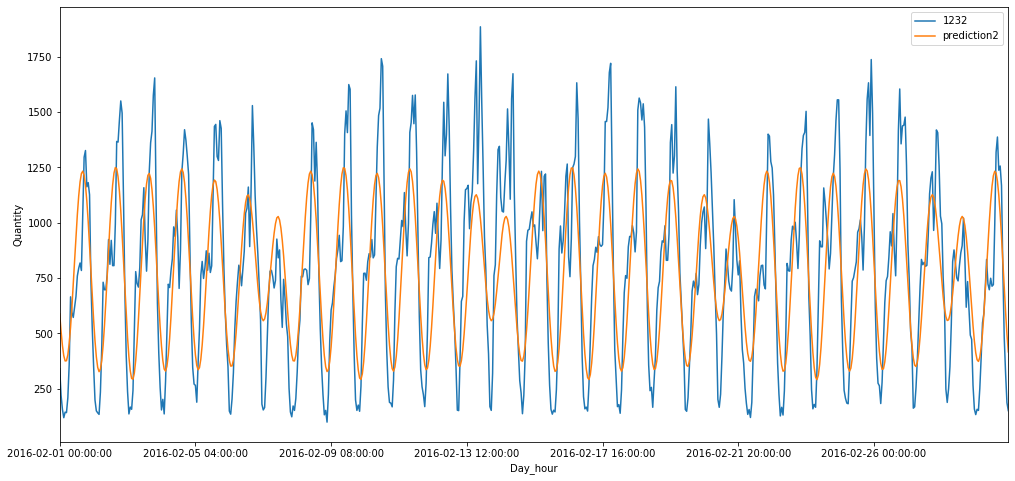

In [86]:
# Строим график количества поездок по времени на февраль
plt.figure(figsize(17,8))
data[744:700+744].plot(x='Day_hour', y=['1232', 'prediction2'])
plt.xlabel('Day_hour')
plt.ylabel('Quantity')
pylab.show()

In [87]:
lr1.coef_ # Значения коэффициентов линейного регрессора

array([ -23.12892191,   17.982821  ,   27.49533602,    7.40139512,
        -18.96535794,  -50.10354905,  -35.05433348,   83.59650209,
       -403.84539894,   26.58552715])

In [88]:
data['resid2']=data['1232']-data['prediction2'] # Добавляем в данные столбец с остатками регрессии

Построим график остатков. Тоже только для февраля.

<Figure size 1224x576 with 0 Axes>

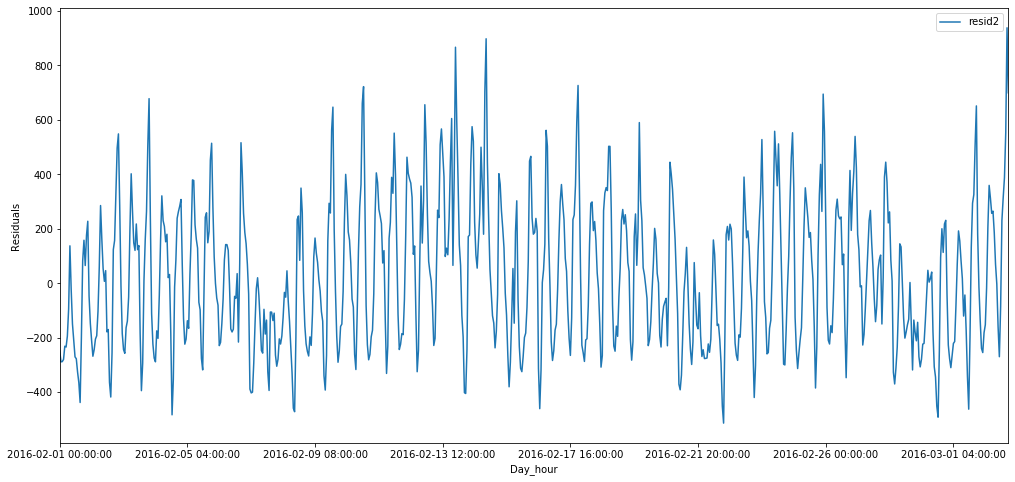

In [89]:
# Строим график остатков по времени для февраля
plt.figure(figsize(17,8))
data[744:744*2].plot(x='Day_hour', y='resid2')
plt.xlabel('Day_hour')
plt.ylabel('Residuals')
pylab.show()

<Figure size 1224x576 with 0 Axes>

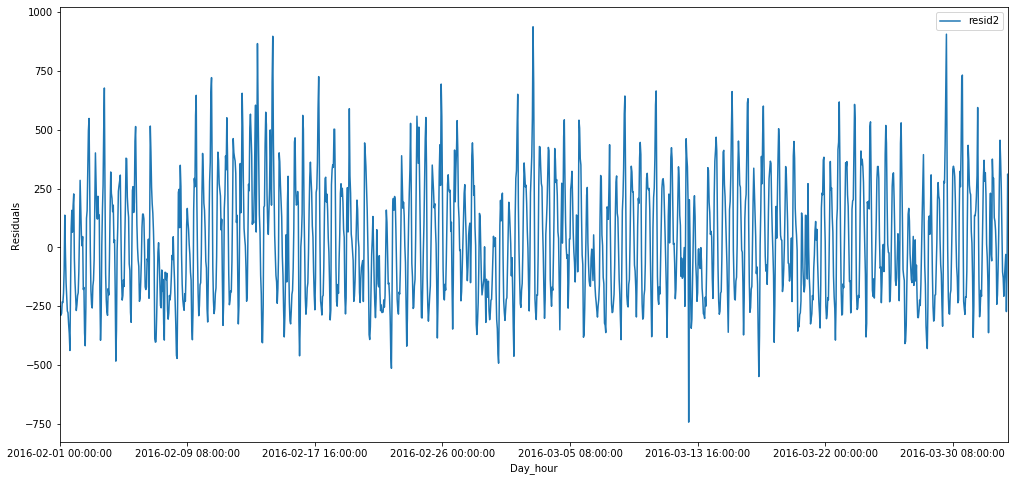

In [90]:
# Строим график остатков по времени для февраля и марта
plt.figure(figsize(17,8))
data[744:744*3].plot(x='Day_hour', y='resid2')
plt.xlabel('Day_hour')
plt.ylabel('Residuals')
pylab.show()

Что можно сказать про график остатков:
1. Есть суточная сезонность и недельная.
2. Месячной сезонности я не вижу.
3. Есть аномалии - празники, дни с повышенным и пониженным спросом на такси.
4. Тренда вроде бы не видно.

Сделаем все необходимые дифференцирования: сезонное и два простых.

In [91]:
data['resid2_sez'] = data.resid2 - data.resid2.shift(24)#Сезонное дифференцирование по суткам
data['resid2_sez_diff'] = data.resid2_sez - data.resid2_sez.shift(1)#Простое дифференцирование
data['resid2_sez_diff_diff'] = data.resid2_sez_diff - data.resid2_sez_diff.shift(1)#Простое дифференцирование еще раз

Построим STL декомпозицию.

<Figure size 1080x1080 with 0 Axes>

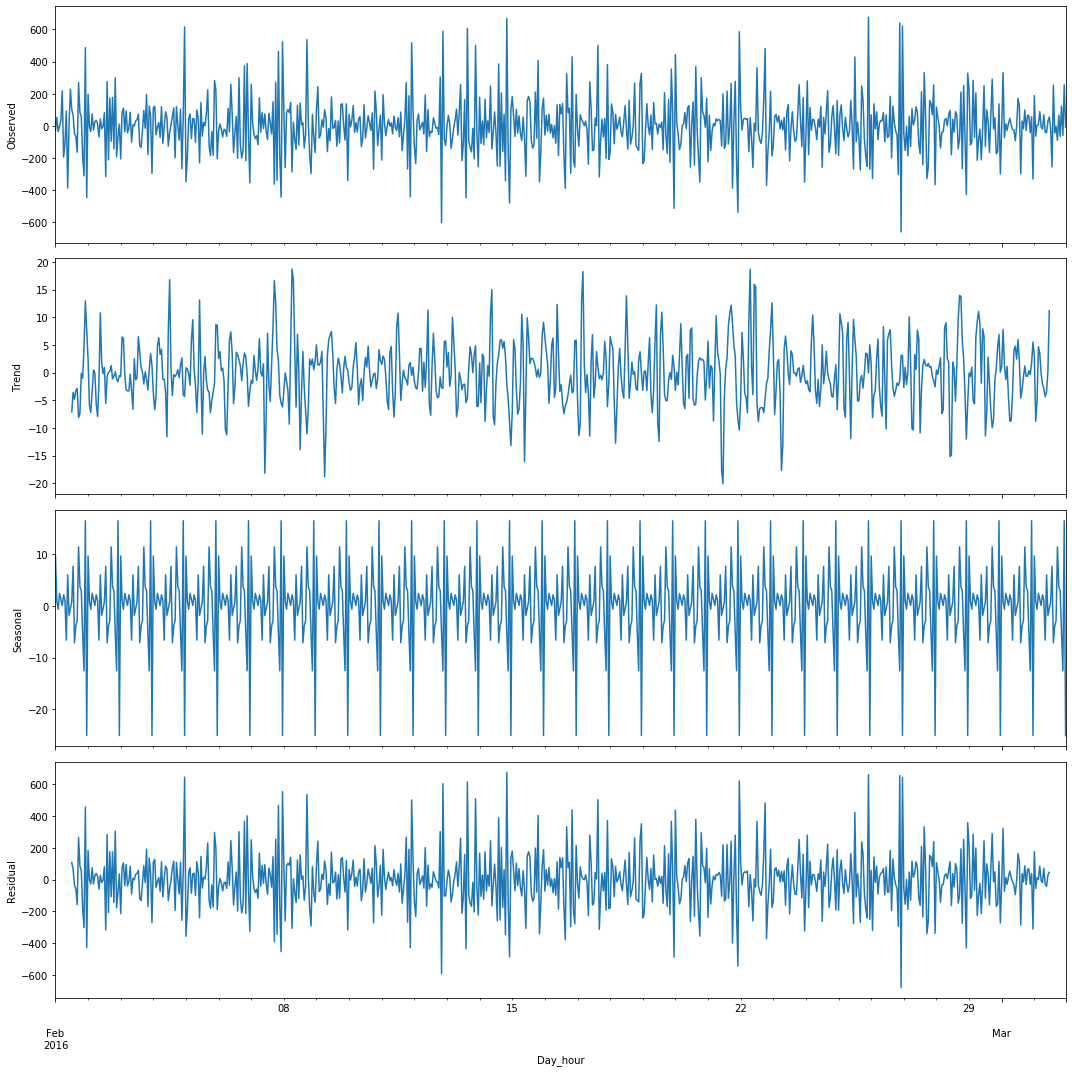

In [92]:
#Сделаем STL-декомпозицию.
plt.figure(figsize(15,15))
sm.tsa.seasonal_decompose(data.iloc[744:744*2].resid2_sez_diff_diff).plot()
pylab.show()

Построим ACF и PACF.

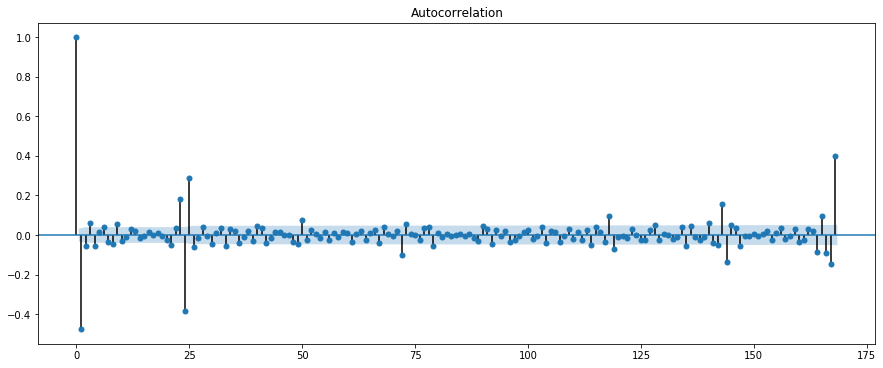

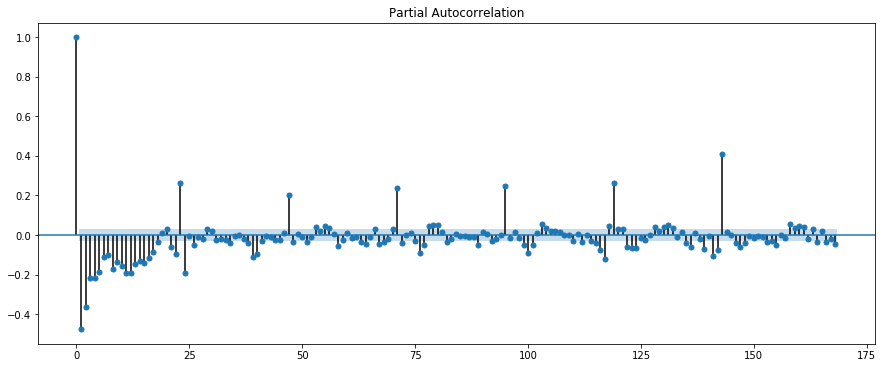

In [93]:
plt.figure(figsize(15,13))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.resid2_sez_diff_diff[26:].values.squeeze(), lags=168, ax=ax)#Строит автокреляцию
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.resid2_sez_diff_diff[26:].values.squeeze(), lags=168, ax=ax)#Строит частичную автокореляцию
pylab.show()

Графики на декомпозиции выглядят красиво. Возьмем первые приближения параметров SARIMы из автокореляции и частичной автокореляции после одного сезонного и двух обычных дифференцирований. D=1, d=2, Q=1, q=1, P=1, p=2

In [94]:
#Создадим отдельные дата-сеты целевого признака и регрессионных признаков. Надеюсь это ускорит процесс обучения модели.
target2=data['resid2'].copy(deep=True)
exog2=data[['s3','c3', 's4', 'c4', 's5', 'c5','s6','c6','s7','c7']].copy(deep=True)

In [95]:
#Задаем интервалы, в которых будем перебирать значения параметров модели ARIMA
ps = range(1, 3)
d=2
qs = range(1, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)


In [96]:
#Создаем массив комбинаций параметров
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters) 
len(parameters_list)

16

Находим оптимальные параметры модели

In [97]:
%%time
results2 = []
best_aic2 = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model2=sm.tsa.statespace.SARIMAX(target2, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24),
                                        exog=exog2).fit(disp=-1, maxiter=20)
    
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic2 = model2.aic
    #сохраняем лучшую модель, aic, параметры
    if aic2 < best_aic2:
        best_model2 = model2
        best_aic2 = aic2
        best_param2 = param
    results2.append([param, model2.aic])
    
warnings.filterwarnings('default')

Wall time: 27min 6s


In [99]:
#Создаем таблицу результатов настроек моделей
result_table2 = pd.DataFrame(results2)
result_table2.columns = ['parameters', 'aic']
print(result_table2.sort_values(by = 'aic', ascending=True).head())

      parameters           aic
3   (1, 1, 1, 1)  44507.256128
15  (2, 2, 1, 1)  44512.196732
7   (1, 2, 1, 1)  44514.076744
11  (2, 1, 1, 1)  44552.886716
9   (2, 1, 0, 1)  44641.192067


Лучшая модель:

In [100]:
print(best_model2.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             resid2   No. Observations:                 3648
Model:             SARIMAX(1, 2, 1)x(1, 1, 1, 24)   Log Likelihood              -22238.628
Date:                            Wed, 28 Aug 2019   AIC                          44507.256
Time:                                    12:21:33   BIC                          44600.178
Sample:                                01-01-2016   HQIC                         44540.361
                                     - 05-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
s3             6.5307     19.881      0.328      0.743     -32.435      45.496
c3             7.5772     22.724   

Проанализируем остатки:

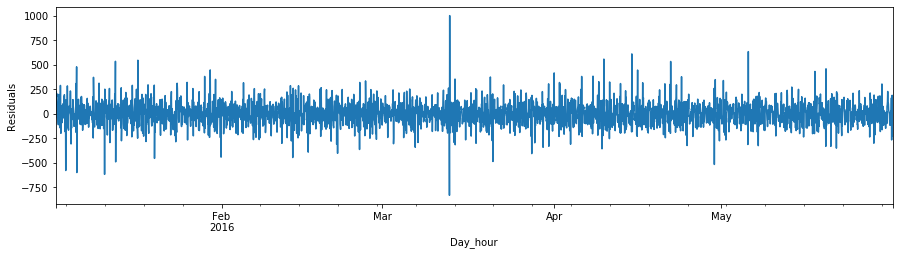

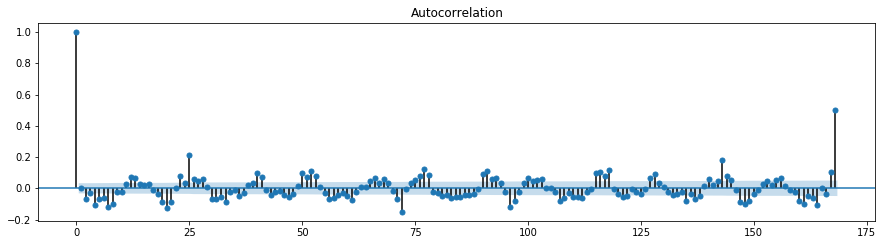

Критерий Стьюдента: p=0.557358
Критерий Дики-Фуллера: p=0.000000


In [101]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model2.resid[26:].plot() #Так рисуем график остатков модели
plt.ylabel(u'Residuals')
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model2.resid[26:].values.squeeze(), lags=168, ax=ax)#Рисуем график автокореляции остатсков модели
pylab.show()
#Считаем крит Стюд гипотезы о несмещенности остатков (нормальное распределение вокруг нуля)
print("Критерий Стьюдента: p=%f" % scs.ttest_1samp(best_model2.resid[26:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model2.resid[26:])[1])#Считаем крит Дики-Фулера для остатков

Остатки не смещены (критерий Стьюдента) и стационарны (критерий Дики-Фуллера)

In [102]:
#Добавляем предсказания модели в данные
data['sarimax2']=data.prediction2+best_model2.fittedvalues

Построим графики фактического значения поездок и предсказаний модели. Помесячно, чтоб было удобно анализировать.

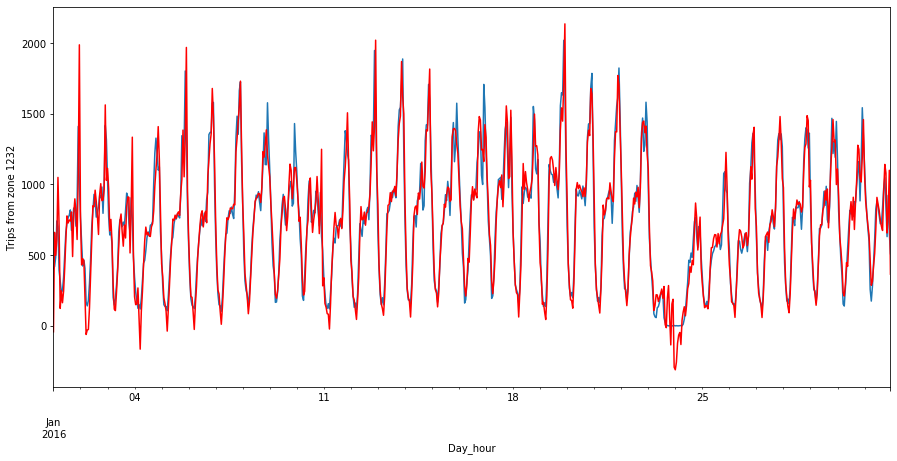

In [103]:
# Строим графики фактического значения данных и предсказаний за январь
plt.figure(figsize(15,7))
data['1232'][0:744].plot()
data.sarimax2[0:744].plot(color='r')
plt.ylabel('Trips from zone 1232')
pylab.show()

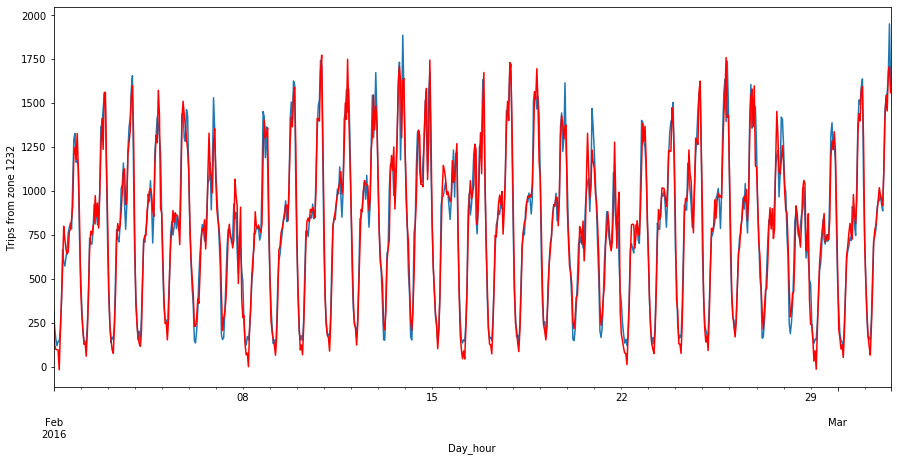

In [104]:
# Строим графики фактического значения данных и предсказаний за февраль
plt.figure(figsize(15,7))
data['1232'][744:744*2].plot()
data.sarimax2[744:744*2].plot(color='r')
plt.ylabel('Trips from zone 1232')
pylab.show()

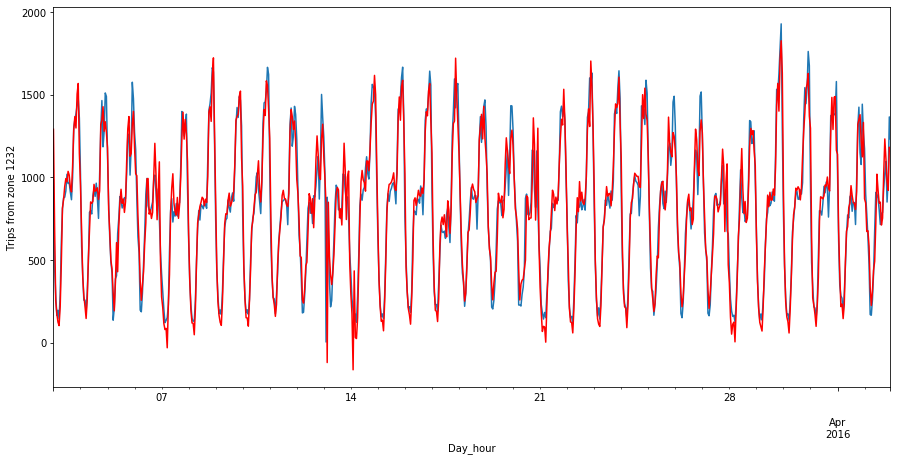

In [105]:
# Строим графики фактического значения данных и предсказаний за март
plt.figure(figsize(15,7))
data['1232'][744*2:744*3].plot()
data.sarimax2[744*2:744*3].plot(color='r')
plt.ylabel('Trips from zone 1232')
pylab.show()

Построим графики исходного ряда, предсказаний модели с 3 признаками и предсказаний модели с 5 признаками. Для одной из недель января, где есть провал в числе поездок.

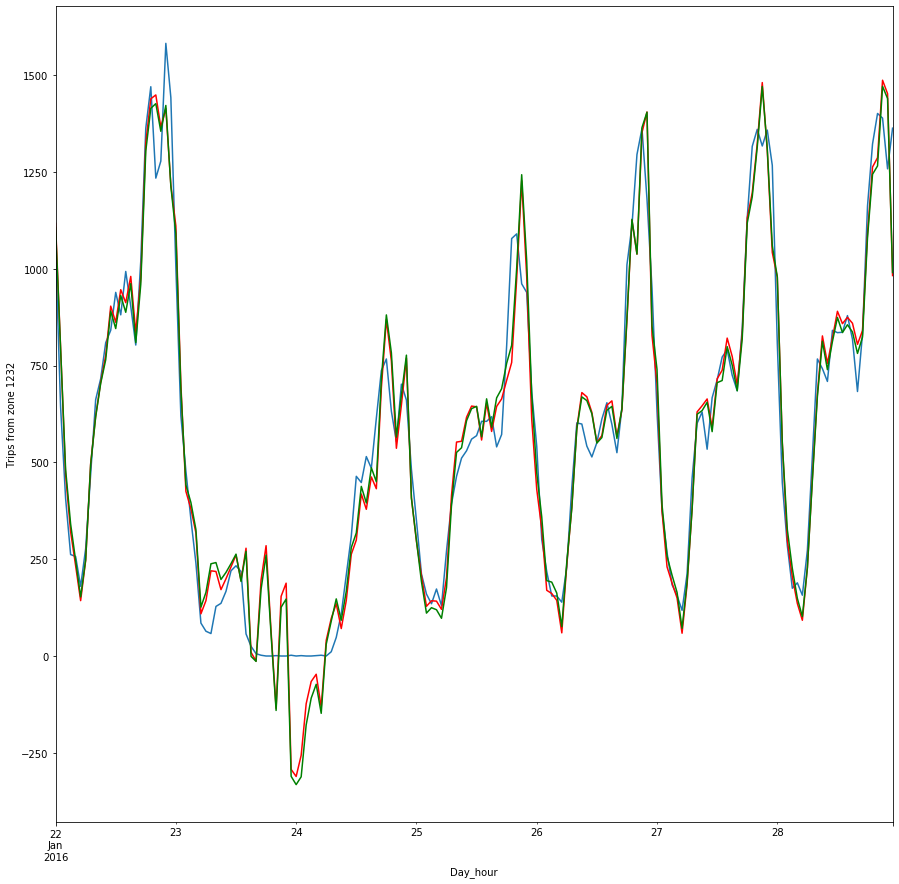

In [106]:
# Строим графики фактического значения данных и предсказаний за 4ю неделю января
plt.figure(figsize(15,15))
data['1232'][168*3:168*4].plot()
data.sarimax2[168*3:168*4].plot(color='r')
data.sarimax1[168*3:168*4].plot(color='g')
plt.ylabel('Trips from zone 1232')
pylab.show()

Заключение.
Что мы видим на графиках:
1. Модель вполне хорошо отрабатывает обычные дни_часы. Но иногда дает значения поездок меньше нуля.
2. Модель так себе отрабатывает экстремальные дни_часы. В январе провал нашелся, но количество поездок спрогнозировалось плохо.
Чтобы с этим побороться нужно добовлять какие то признаки, выделяющие экстремальные дни. Наилучшим будет задавать модели предсказания погоды из другой модели, которая будет предсказывать погоду.
3. Разница в работе моделей с 3я и 5ю парами признаков не значительная.